In [1]:
from itertools import zip_longest
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
from scipy.signal import argrelextrema, find_peaks
import numpy as np
import pandas as pd

from constants import *
from phe import *
import series as s

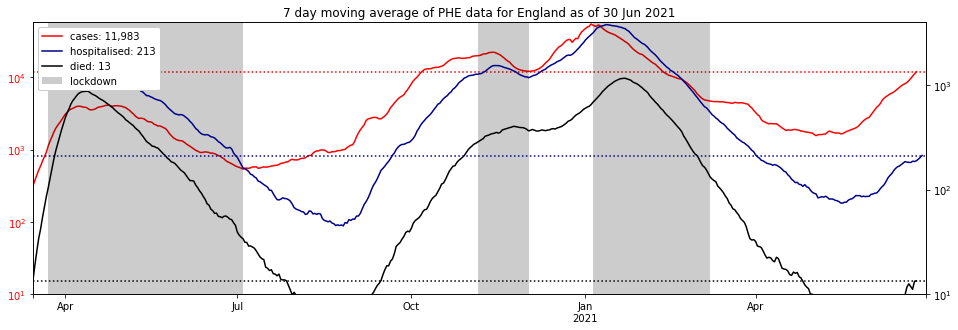

In [2]:
plot_summary(earliest_date=data_start, show_latest='lines', log=True,
             left_series=(s.new_cases_sum,),
             right_series=(s.new_admissions_sum, s.new_deaths_sum))

In [3]:
def waves(phe_series, title, sax=None, wax=None, rat=None, n=15):
    data, _ = summary_data([phe_series])
    data.index.name = None
    metric = phe_series.metric
    
    if sax is None:
        fig, (sax, wax, rat) = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), dpi=150)
        fig.set_facecolor('white')
    
    series = data[metric]
    minima = series.index[argrelextrema(series.values, np.less, order=n)[0]]
    maxima = series.index[argrelextrema(series.values, np.greater, order=n)[0]]
    waves =  list(zip_longest(minima, maxima[1:]))

    series.plot(logy=True, c='grey', ax=sax, title=title)
    series.loc[minima].plot(c='g', style='.', ax=sax)
    series.loc[maxima].plot(c='r', style='.', ax=sax)
    sax.title.set_fontweight('bold')
    
    df = pd.DataFrame()
    colours = []
    maxes = []
    
    for i, (start, end) in enumerate(waves, start=2):
        colour = cm.tab10(i)
        colours.append(colour)
        wave_data = data[metric].loc[start:end]
        wave_data.plot(ax=sax, color=colour)
        series = wave_data.reset_index()[metric]
        series -= series[0]
        name = f'Wave {i}, {start:%b %y}'
        df[name] = series
        maxes.append((series.max(), name))
                     
    df.index.name = 'days'
    df.plot(logy=True, title='Relative to Wave Start', ax=wax, color=colours)    
    wax.legend(loc='lower right')
    
    relative_to_name = sorted(maxes)[-1][1]
    relative_to = df[relative_to_name]
    relative_to.fillna(relative_to.max(), inplace=True)
    ratio = df.divide(relative_to, axis='rows')
    ratio.plot(ax=rat, color=colours, legend=False, title='Relative to Worst', ylim=(0, 1))
    rat.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y*100:,.0f}%"))

In [4]:
def plot_all(*, figsize, dpi=150, **adjust):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize, dpi=dpi)
    fig.set_facecolor('white')
    if adjust:
        fig.subplots_adjust(**adjust)
    for i, (series, title, n) in enumerate((
        (s.new_cases_sum, 'Cases', 15),
        (s.new_admissions_sum, 'Hospital Admissions', 10),
        (s.new_deaths_sum, 'Deaths', 15),
    )):
        sax, wax, rat = axes.T[i]
        waves(series, title, sax, wax, rat, n)

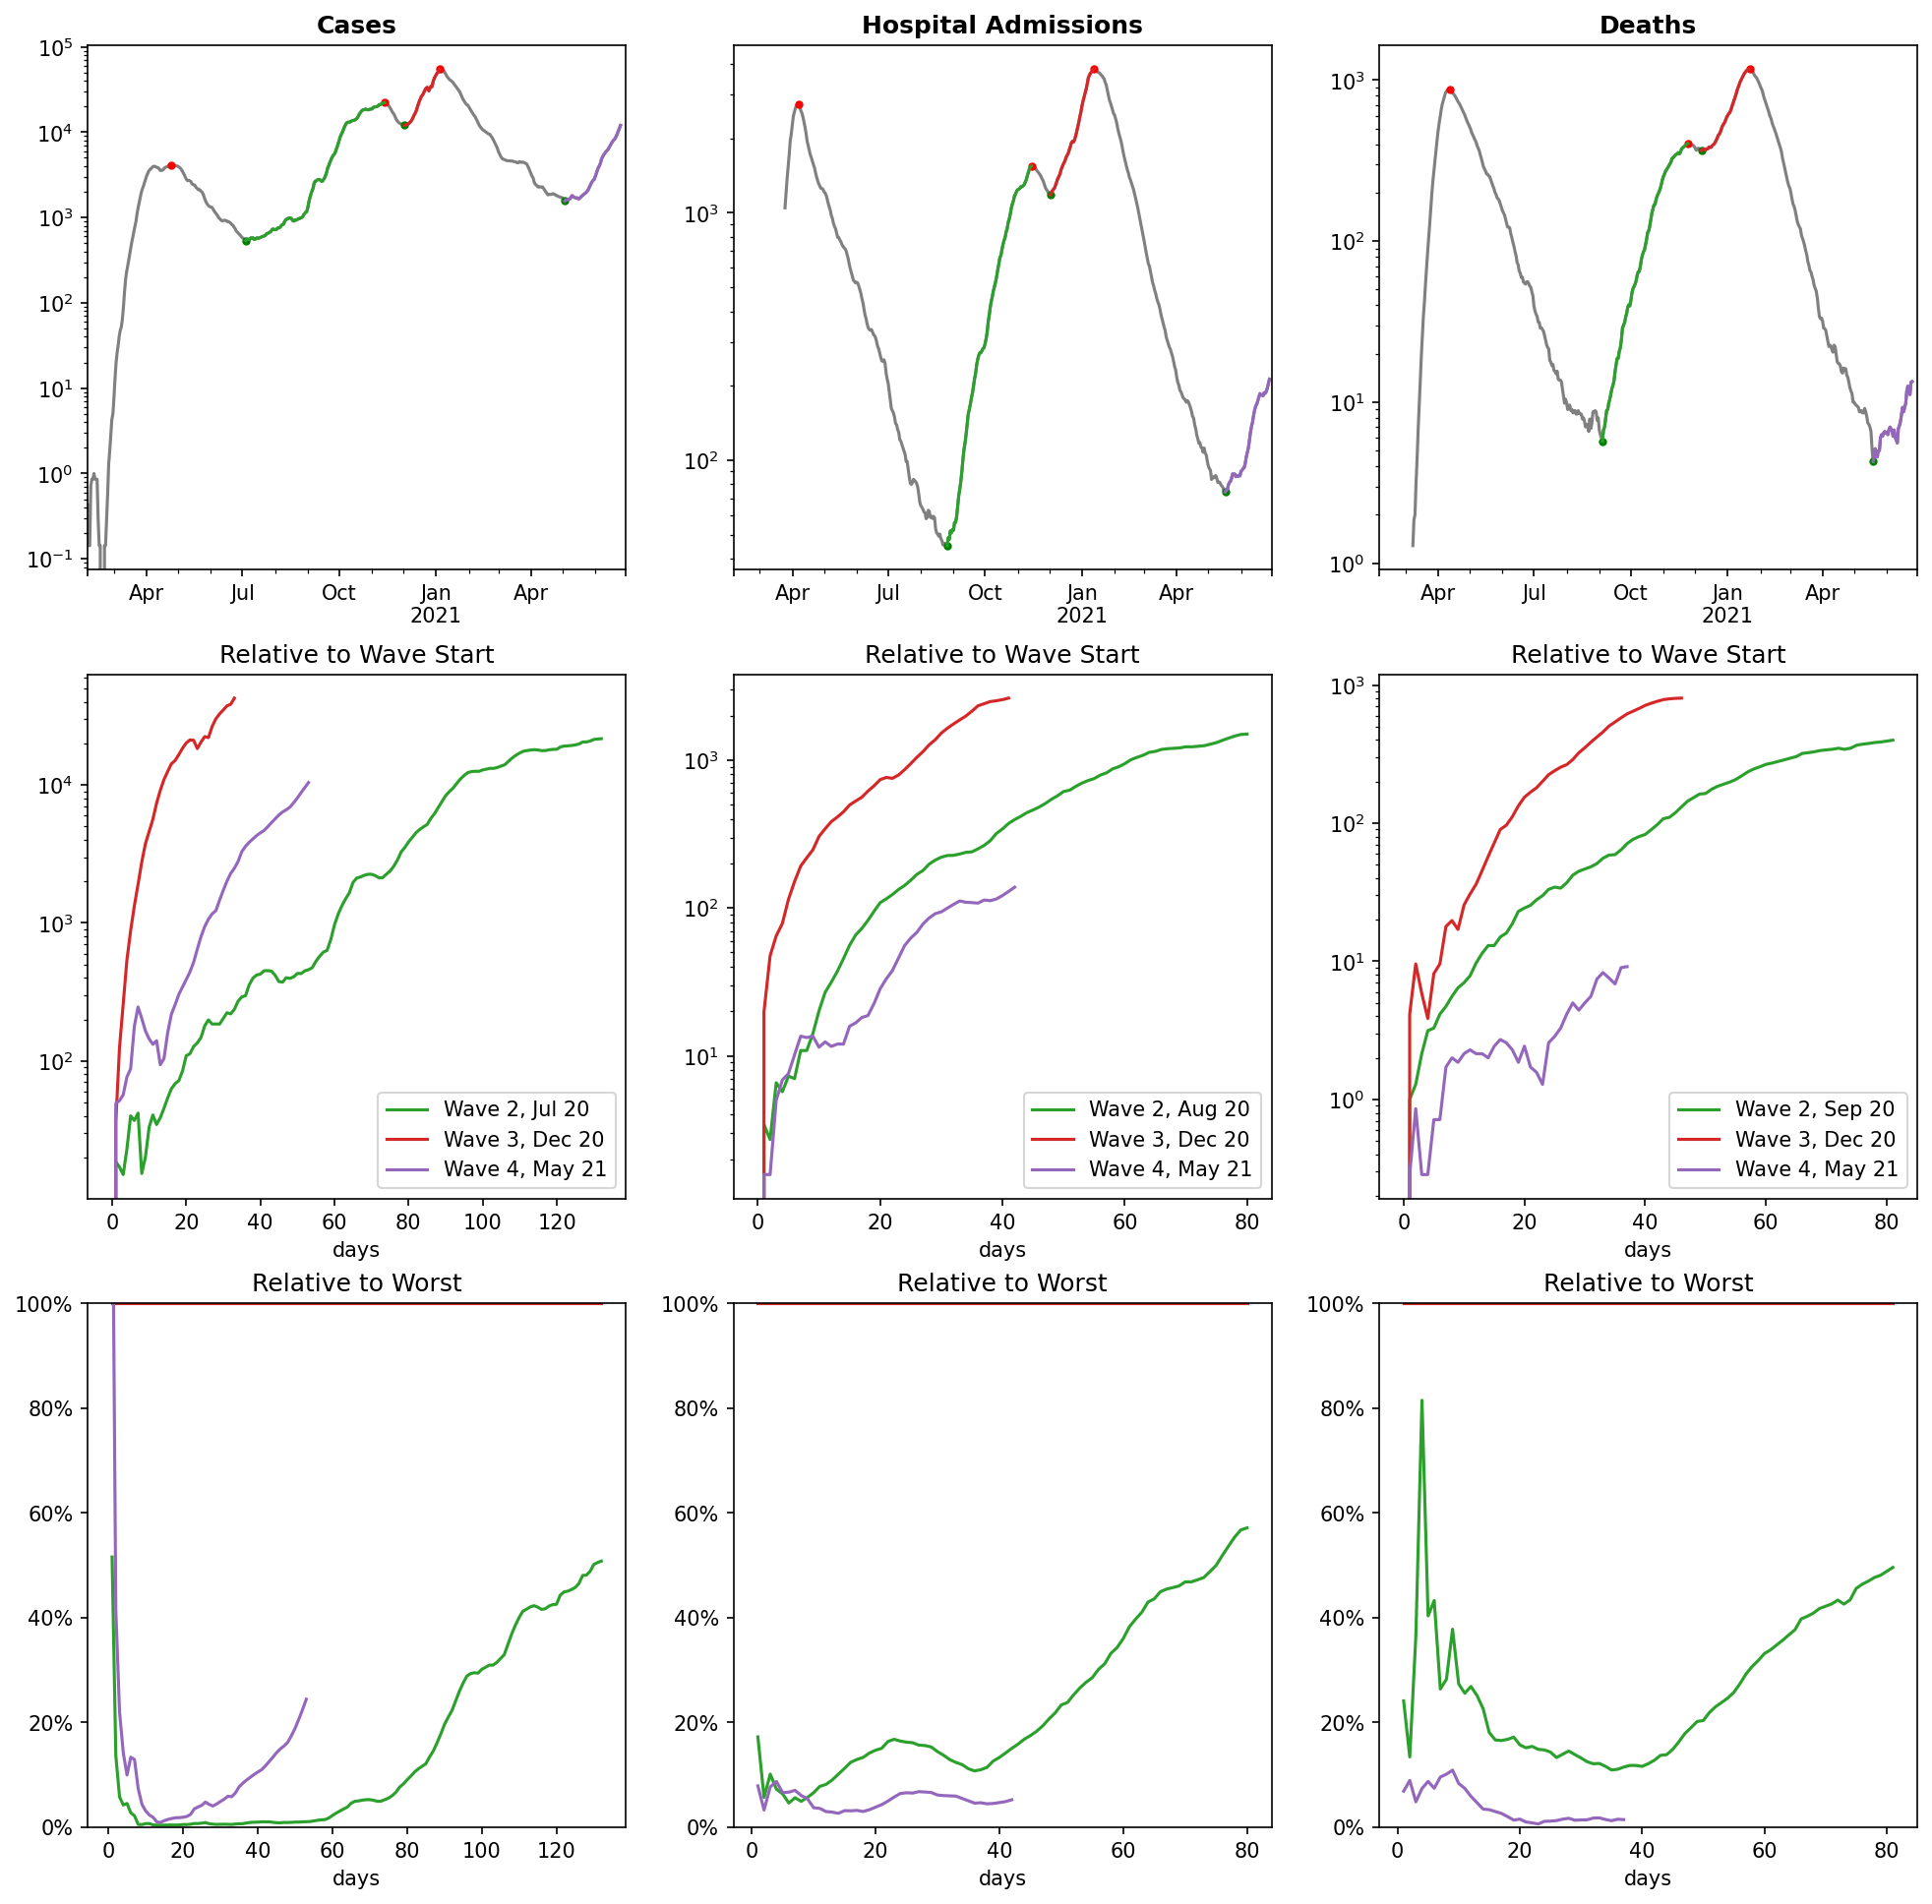

In [5]:
plot_all(figsize=(16, 16))

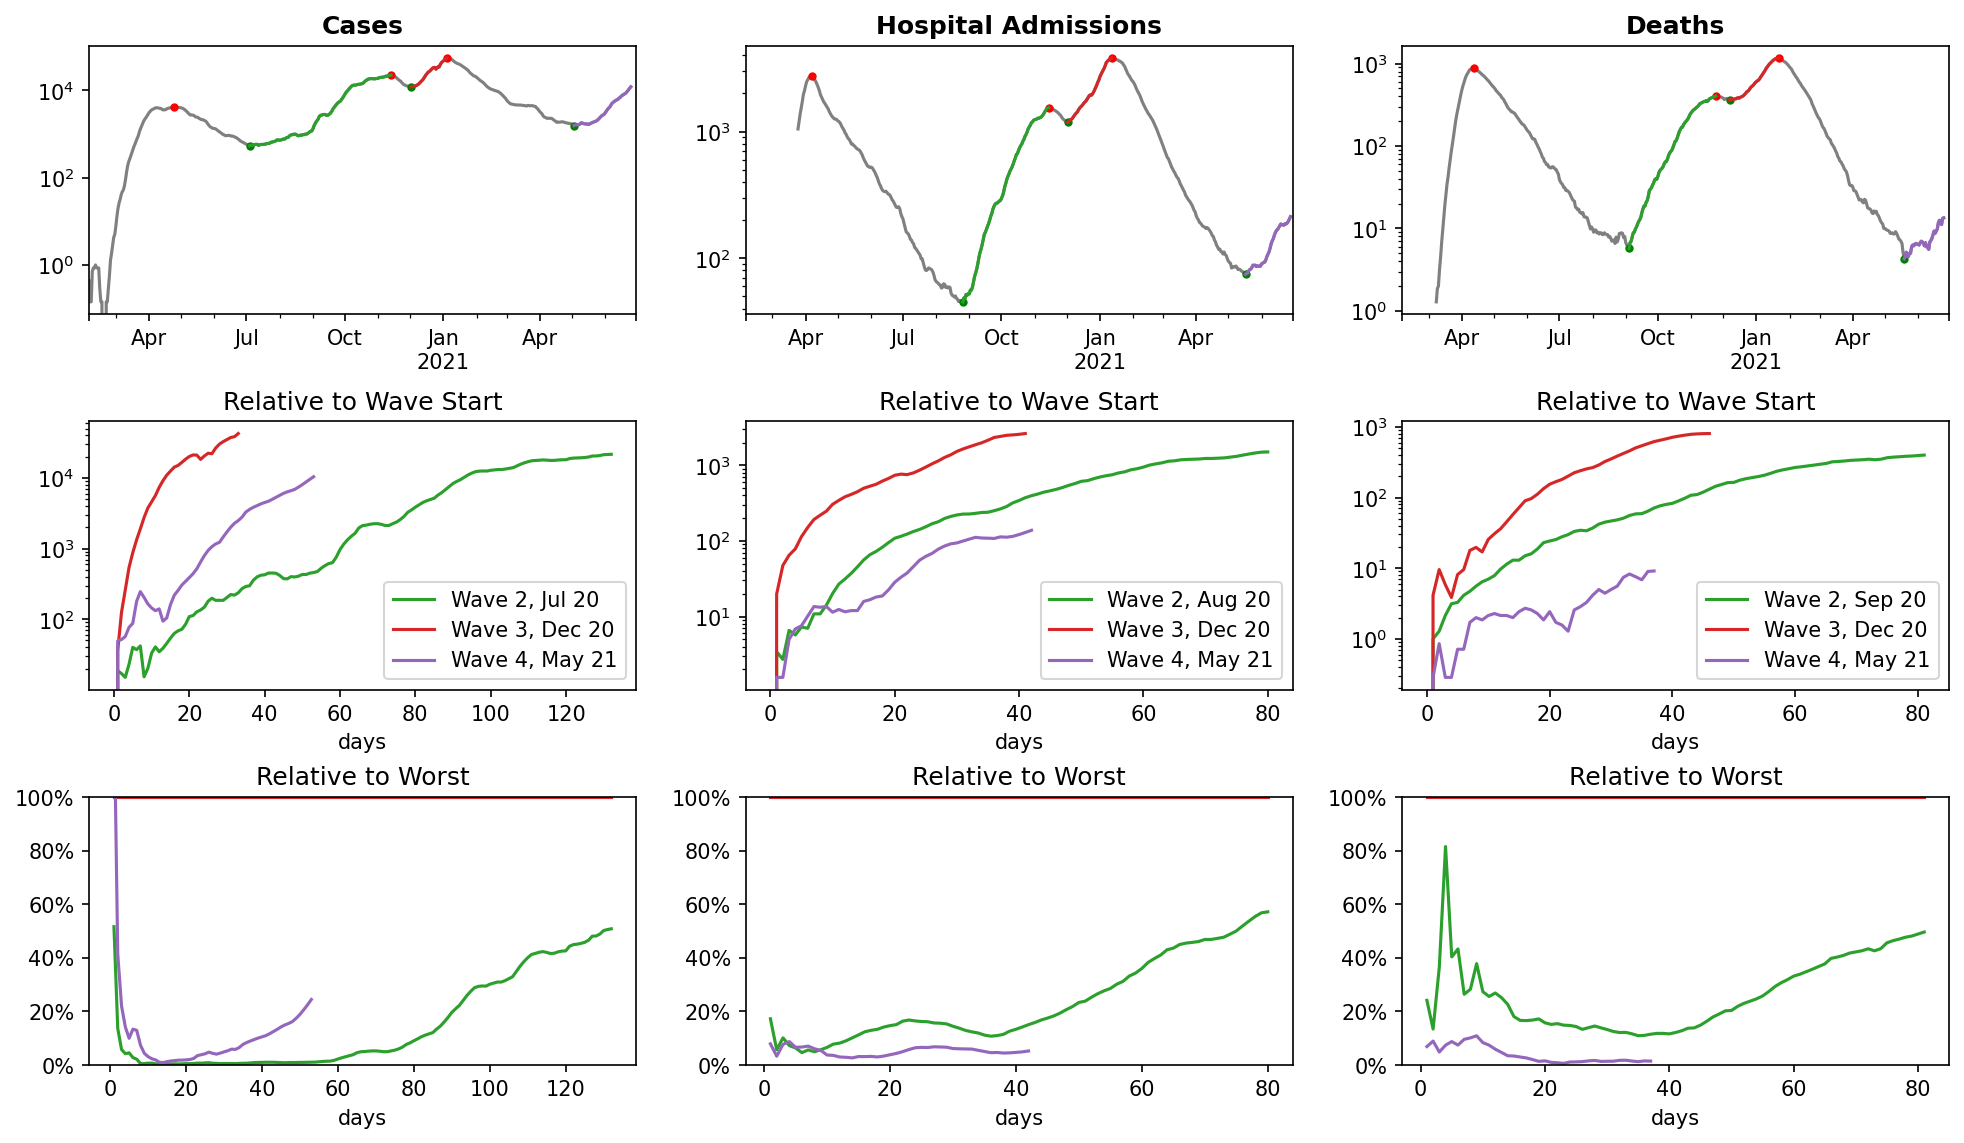

In [6]:
plot_all(figsize=(16, 9), hspace=0.4)

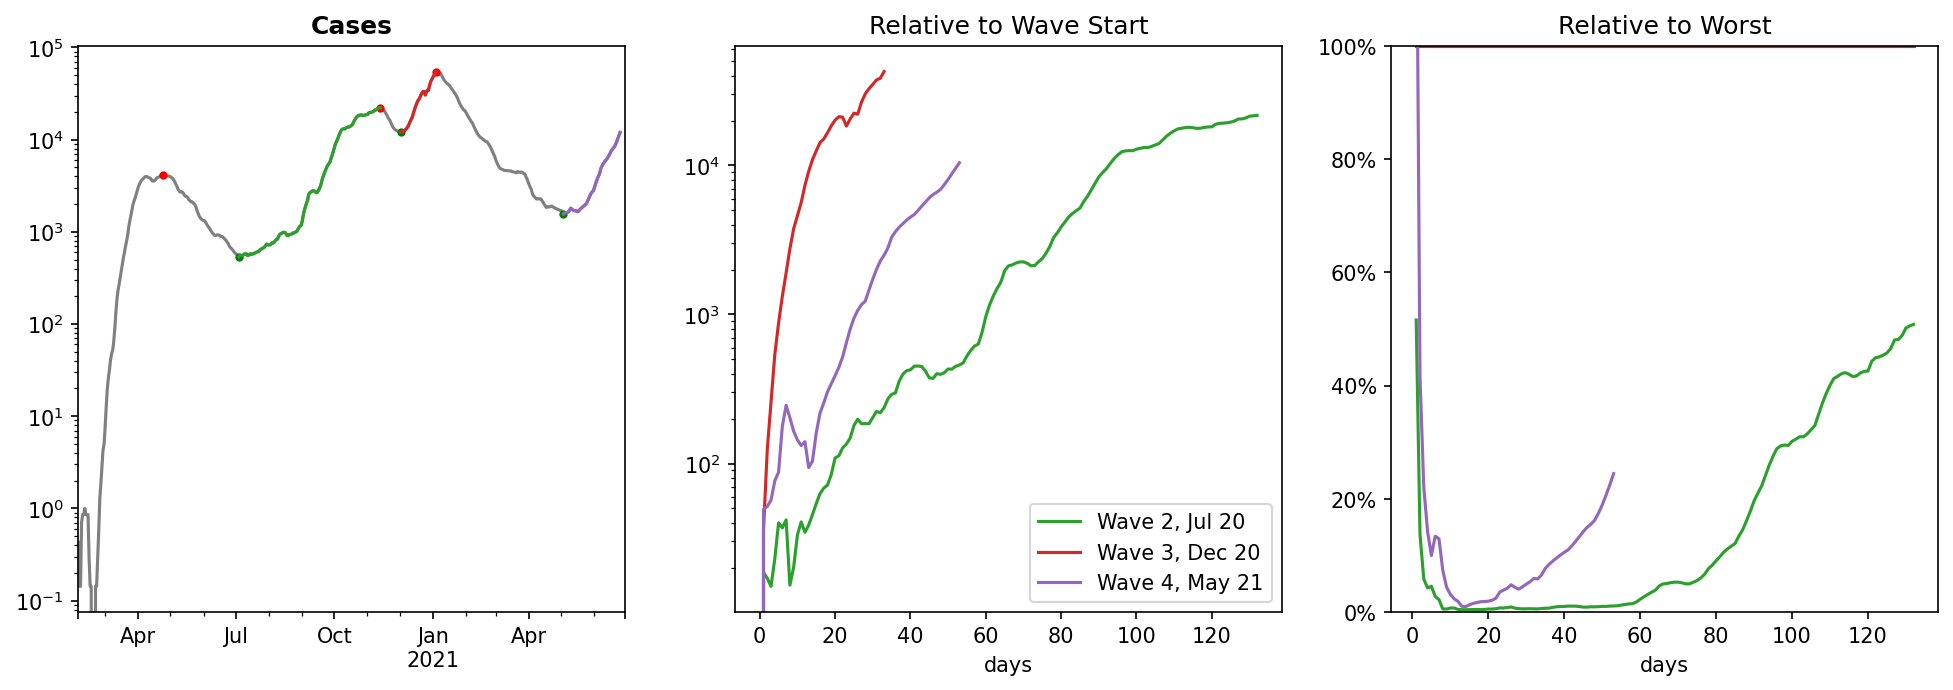

In [7]:
waves(s.new_cases_sum, 'Cases')

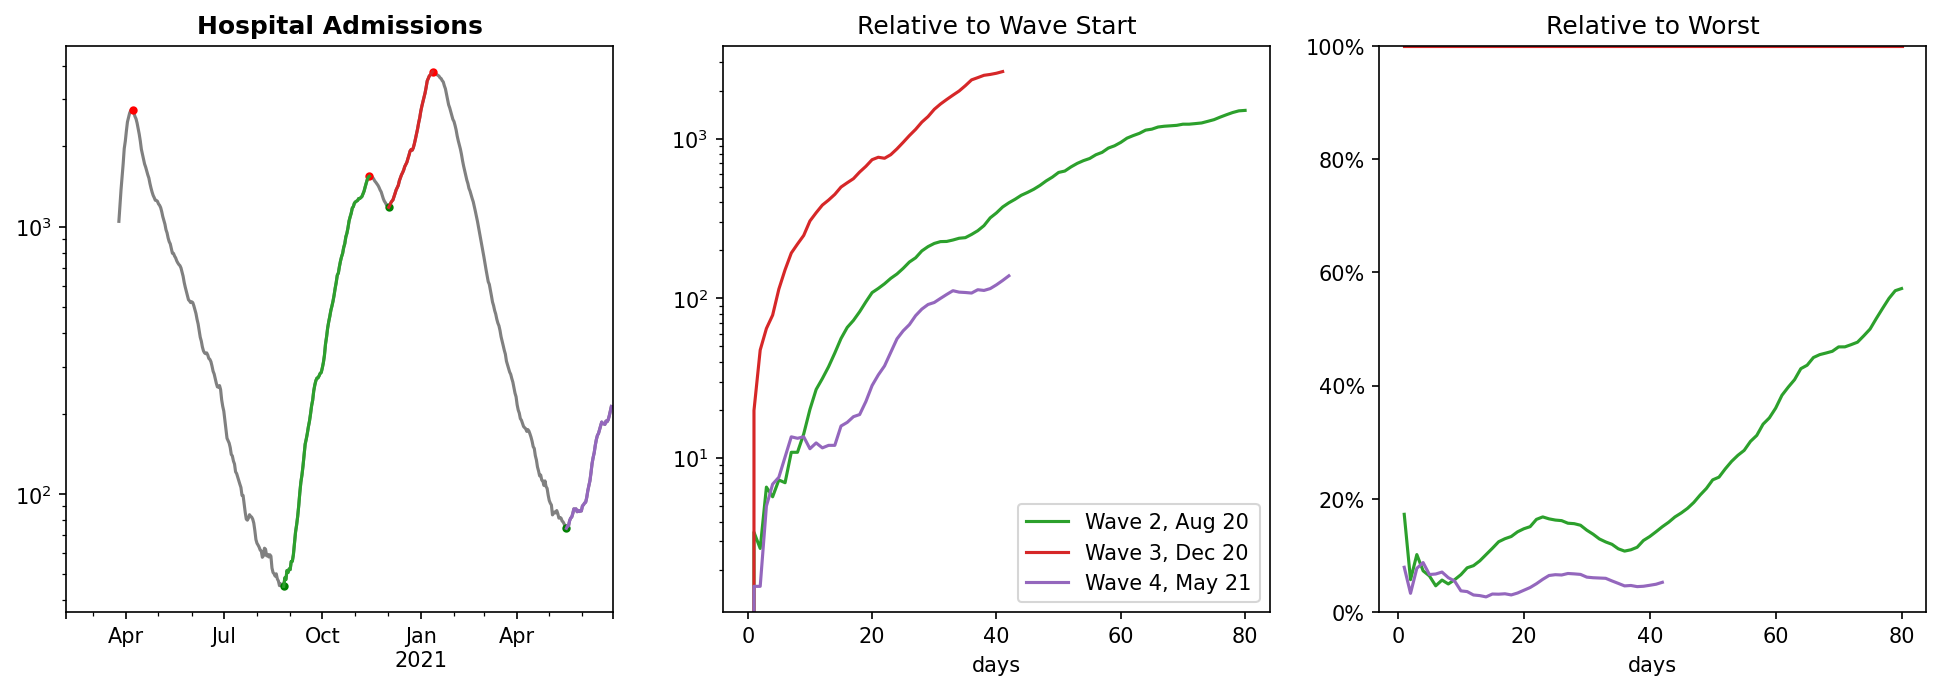

In [8]:
waves(s.new_admissions_sum, 'Hospital Admissions', n=10)

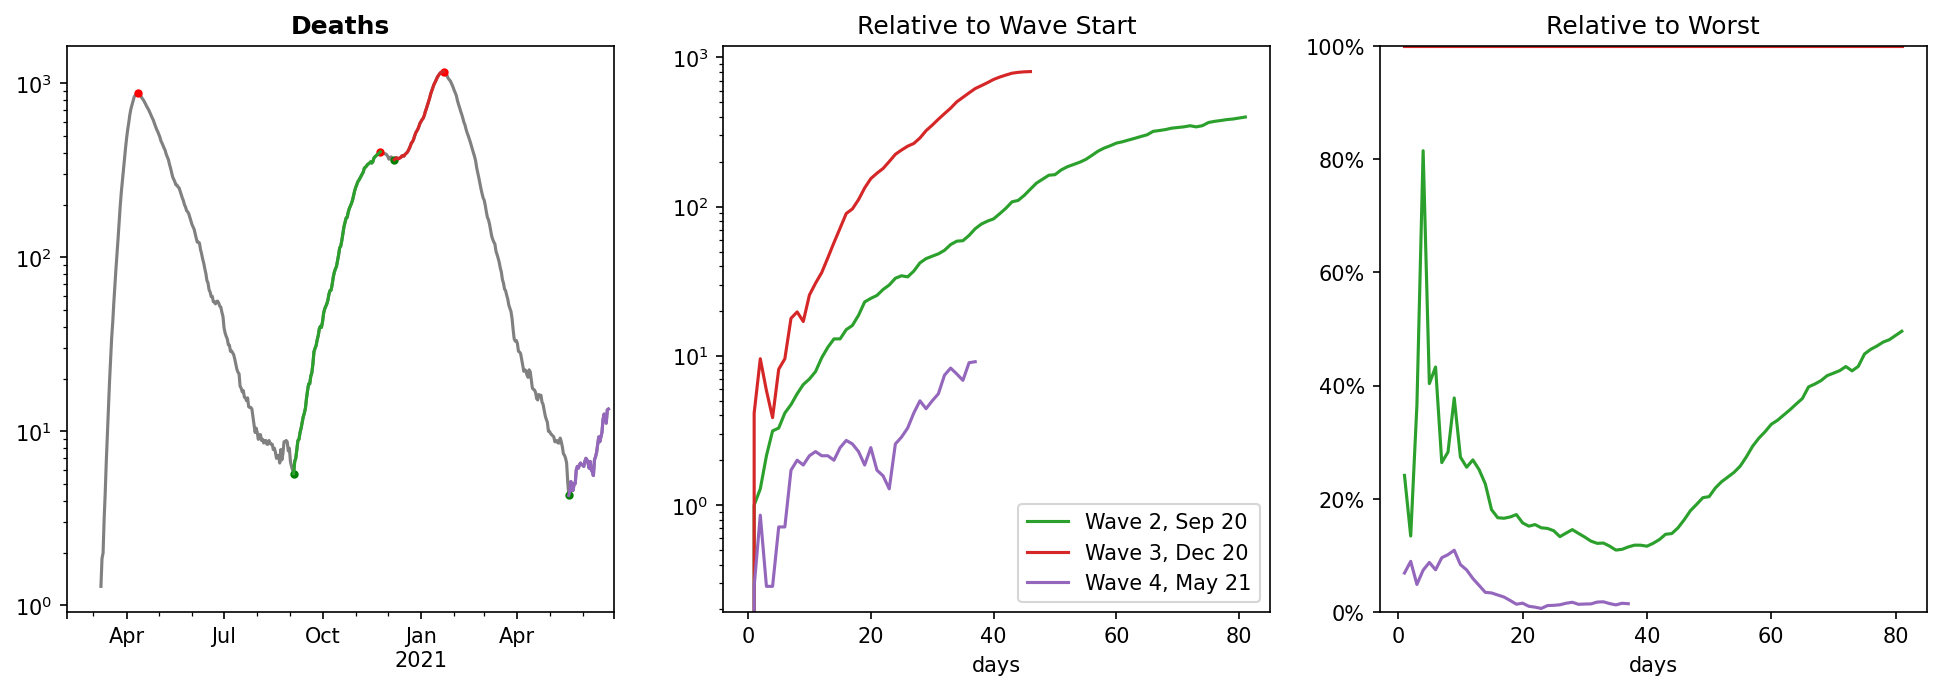

In [9]:
waves(s.new_deaths_sum, 'Deaths')